## semantic-segmentation-and-dataset

### 13.9.2. Pascal VOC2012 语义分割数据集

In [1]:
%matplotlib inline
import os
import mindspore
from d2l import mindspore as d2l

In [2]:
#@save
d2l.DATA_HUB['voc2012'] = (d2l.DATA_URL + 'VOCtrainval_11-May-2012.tar',
                           '4e443f8a2eca6b1dac8a6c57641b67dd40621a49')

voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')

In [3]:
#@save
def read_voc_images(voc_dir, is_train=True):
    """读取所有VOC图像并标注"""
    txt_fname = os.path.join(voc_dir, 'ImageSets', 'Segmentation',
                             'train.txt' if is_train else 'val.txt')
    mode = mindspore.dataset.vision.ImageReadMode.COLOR
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    features, labels = [], []
    for i, fname in enumerate(images):
        features.append(mindspore.dataset.vision.read_image(os.path.join( # read as numpy.ndarray
            voc_dir, 'JPEGImages', f'{fname}.jpg')))
        labels.append(mindspore.dataset.vision.read_image(os.path.join(
            voc_dir, 'SegmentationClass' ,f'{fname}.png'), mode))
    return features, labels

train_features, train_labels = read_voc_images(voc_dir, True)

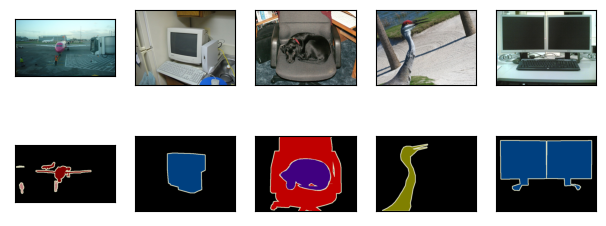

In [4]:
n = 5
imgs = train_features[0:n] + train_labels[0:n]
# the imgs is hwc, so we don't need permute
d2l.show_images(imgs, 2, n);

In [5]:
#@save
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]

#@save
VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

In [6]:
#@save
import numpy as np

def voc_colormap2label():
    """构建从RGB到VOC类别索引的映射"""
    colormap2label = np.zeros(256 ** 3, dtype=np.int64)
    for i, colormap in enumerate(VOC_COLORMAP):
        colormap2label[
            (colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i
    return colormap2label

#@save
def voc_label_indices(colormap, colormap2label):
    """将VOC标签中的RGB值映射到它们的类别索引"""
    colormap = colormap.astype('int32')
    idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256
           + colormap[:, :, 2])
    return colormap2label[idx]

In [7]:
y = voc_label_indices(train_labels[0], voc_colormap2label())
y[105:115, 130:140], VOC_CLASSES[1]

(array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]]),
 'aeroplane')

#### 13.9.2.1. 预处理数据

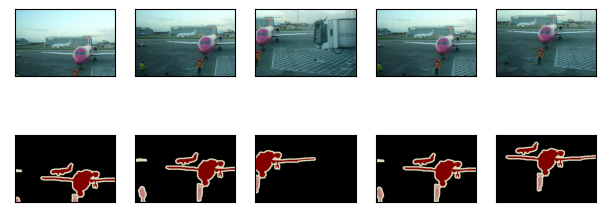

In [8]:
#@save
def voc_rand_crop(feature, label, height, width):
    """随机裁剪特征和标签图像"""
    rect = d2l.get_params(feature, (height, width))
    feature = d2l.crop(feature, *rect)
    label = d2l.crop(label, *rect)
    return feature, label

imgs = []
for _ in range(n):
    imgs += voc_rand_crop(train_features[0], train_labels[0], 200, 300)

d2l.show_images(imgs[::2] + imgs[1::2], 2, n);

#### 13.9.2.2. 自定义语义分割数据集类

In [9]:
#@save
class VOCSegDataset():
    """一个用于加载VOC数据集的自定义数据集"""

    def __init__(self, is_train, crop_size, voc_dir):
        self.transform = mindspore.dataset.vision.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.crop_size = crop_size
        features, labels = read_voc_images(voc_dir, is_train=is_train)
        self.features = [self.normalize_image(feature)
                         for feature in self.filter(features)]
        self.labels = self.filter(labels)
        self.colormap2label = voc_colormap2label()
        print('read ' + str(len(self.features)) + ' examples')

    def normalize_image(self, img):
        return self.transform(img.astype('float32') / 255)

    def filter(self, imgs):
        return [img for img in imgs if (
            img.shape[0] >= self.crop_size[0] and
            img.shape[1] >= self.crop_size[1])]

    def __getitem__(self, idx):
        feature, label = voc_rand_crop(self.features[idx], self.labels[idx],
                                       *self.crop_size)
        return (feature, voc_label_indices(label, self.colormap2label))

    def __len__(self):
        return len(self.features)

#### 13.9.2.3. 读取数据集

In [10]:
crop_size = (320, 480)
voc_train = VOCSegDataset(True, crop_size, voc_dir)
voc_test = VOCSegDataset(False, crop_size, voc_dir)

read 1114 examples
read 1078 examples


In [11]:
batch_size = 64
train_iter = mindspore.dataset.GeneratorDataset(voc_train, column_names=["data", "label"], shuffle=True,
                                                num_parallel_workers =d2l.get_dataloader_workers())
train_iter = train_iter.map(mindspore.dataset.vision.HWC2CHW())
train_iter = train_iter.batch(batch_size=batch_size, drop_remainder=True)

for X, Y in train_iter:
    print(X.shape)
    print(Y.shape)
    break

[WARNING] ME(249222:47692440092032,MainProcess):2023-02-26-21:39:31.574.677 [mindspore/dataset/engine/datasets_user_defined.py:801] GeneratorDataset's num_parallel_workers: 4 is too large which may cause a lot of memory occupation (>85%) or out of memory(OOM) during multiprocessing. Therefore, it is recommended to reduce num_parallel_workers to 1 or smaller.


(64, 3, 320, 480)
(64, 320, 480)


#### 13.9.2.4. 整合所有组件

In [12]:
#@save
def load_data_voc(batch_size, crop_size):
    """加载VOC语义分割数据集"""
    voc_dir = d2l.download_extract('voc2012', os.path.join(
        'VOCdevkit', 'VOC2012'))
    num_workers = d2l.get_dataloader_workers()
    train_iter = mindspore.dataset.GeneratorDataset(VOCSegDataset(True, crop_size, voc_dir), column_names=["data", "label"], 
                                                    shuffle=True, num_parallel_workers =num_workers)
    train_iter = train_iter.map(mindspore.dataset.vision.HWC2CHW())
    train_iter = train_iter.batch(batch_size=batch_size, drop_remainder=True)
    test_iter = mindspore.dataset.GeneratorDataset(VOCSegDataset(False, crop_size, voc_dir), column_names=["data", "label"], 
                                                   shuffle=True, num_parallel_workers =num_workers)
    test_iter = train_iter.map(mindspore.dataset.vision.HWC2CHW())
    test_iter = train_iter.batch(batch_size=batch_size, drop_remainder=True)
    return train_iter, test_iter